In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, MobileNet, InceptionV3, ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np

Organize the Dataset

In [2]:
# absolute path
base_dir = r'C:\BHARGAV\OneDrive\Desktop\Final Project\archive'

# relative path
dataset_dir = 'archive'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories for train, validation, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    images = os.listdir(category_path)
    
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
    
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    
    for image in train_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category, image))
    for image in val_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(validation_dir, category, image))
    for image in test_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category, image))


Load and Preprocess the Dataset

In [3]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load the images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2672 images belonging to 8 classes.
Found 711 images belonging to 8 classes.
Found 878 images belonging to 8 classes.


Visualize the Data

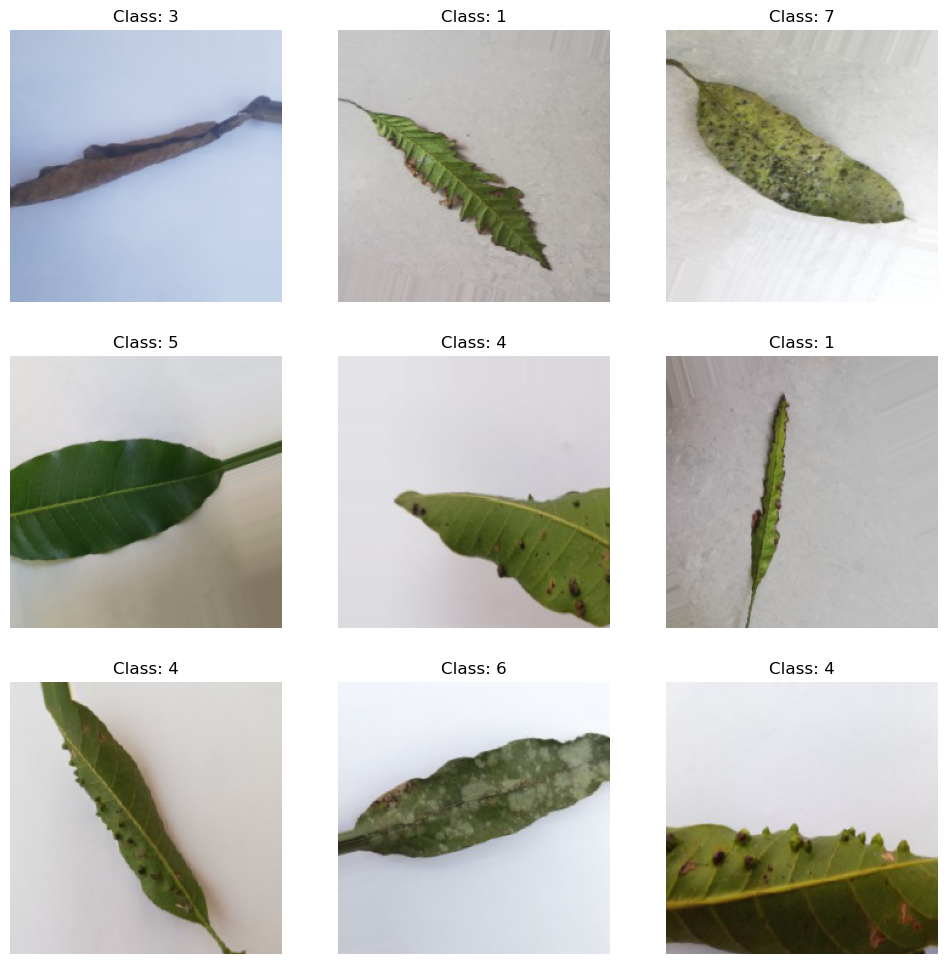

In [4]:
#Visualize Sample Images
# Get a batch of images and labels from the training set
images, labels = next(train_generator)

# Plotting a few images from the dataset
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis('off')
plt.show()


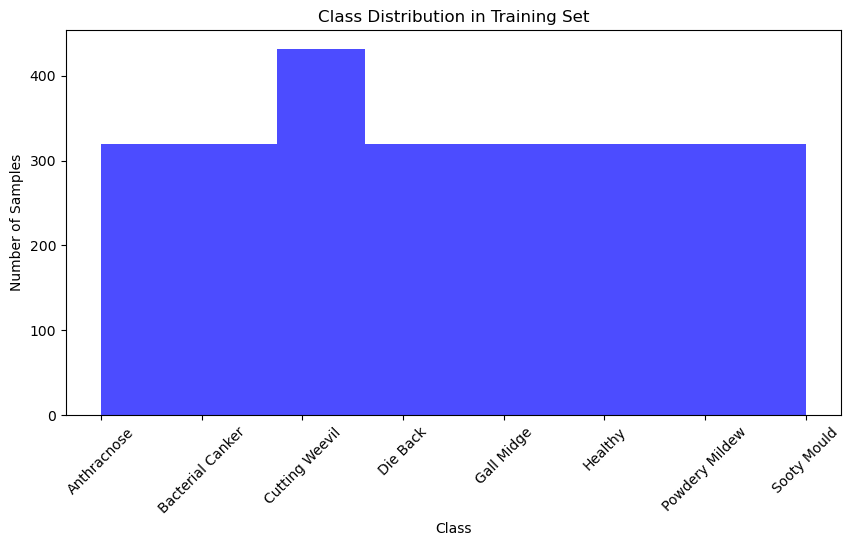

In [5]:
#Visualize the Distribution of Classes
# Counting the number of samples per class
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Plotting class distribution
plt.figure(figsize=(10, 5))
plt.hist(class_counts, bins=len(class_labels), alpha=0.7, color='blue')
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


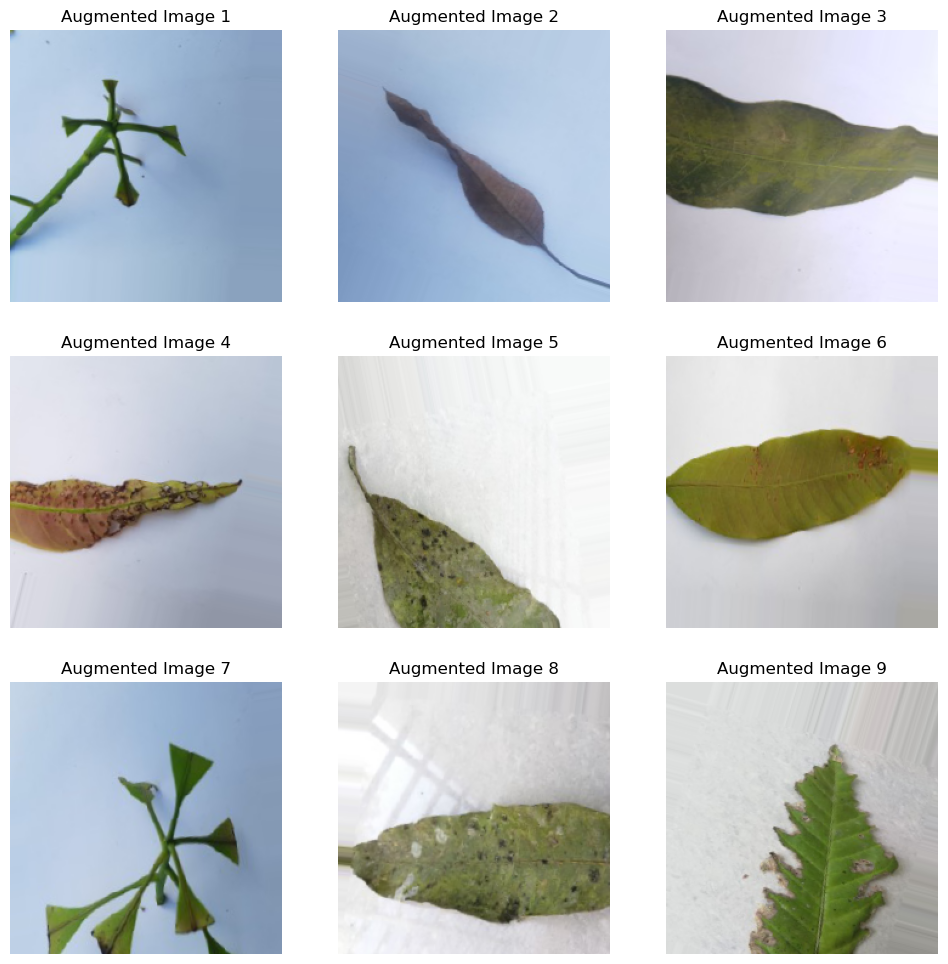

In [6]:
#Visualize Augmented Images
# Generate augmented images from a single image
augmented_images, _ = next(train_generator)

# Plotting a few augmented images
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.title(f"Augmented Image {i+1}")
    plt.axis('off')
plt.show()


# CNN Model

In [7]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = create_cnn_model((224, 224, 3), num_classes=8)
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=5)




Epoch 1/5


84/84 [==============================] - 95s 1s/step - loss: 1.8710 - accuracy: 0.3409 - val_loss: 1.0439 - val_accuracy: 0.6006
Epoch 2/5
84/84 [==============================] - 88s 1s/step - loss: 1.1022 - accuracy: 0.5868 - val_loss: 1.2352 - val_accuracy: 0.6287
Epoch 3/5
84/84 [==============================] - 79s 943ms/step - loss: 0.7381 - accuracy: 0.7279 - val_loss: 0.3987 - val_accuracy: 0.8861
Epoch 4/5
84/84 [==============================] - 86s 1s/step - loss: 0.4644 - accuracy: 0.8301 - val_loss: 0.3156 - val_accuracy: 0.8847
Epoch 5/5
84/84 [==============================] - 81s 963ms/step - loss: 0.4516 - accuracy: 0.8196 - val_loss: 0.5715 - val_accuracy: 0.7961


# MobileNet

In [8]:
def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

mobilenet_model = create_mobilenet_model((224, 224, 3), num_classes=8)
mobilenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

mobilenet_history = mobilenet_model.fit(train_generator, validation_data=validation_generator, epochs=1)

84/84 [==============================] - 50s 577ms/step - loss: 0.2831 - accuracy: 0.9098 - val_loss: 0.0749 - val_accuracy: 0.9705


# VGG19

In [9]:
def create_vgg19_model(input_shape, num_classes):
    base_model = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

vgg19_model = create_vgg19_model((224, 224, 3), num_classes=8)
vgg19_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

vgg19_history = vgg19_model.fit(train_generator, validation_data=validation_generator, epochs=2)

Epoch 1/2
84/84 [==============================] - 532s 6s/step - loss: 1.5870 - accuracy: 0.6557 - val_loss: 0.3288 - val_accuracy: 0.8875
Epoch 2/2
84/84 [==============================] - 579s 7s/step - loss: 0.4142 - accuracy: 0.8574 - val_loss: 0.3467 - val_accuracy: 0.8805


# ResNet50

In [10]:
def create_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

resnet50_model = create_resnet50_model((224, 224, 3), num_classes=8)
resnet50_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_history = resnet50_model.fit(train_generator, validation_data=validation_generator, epochs=5)



Epoch 1/5
84/84 [==============================] - 136s 2s/step - loss: 2.0137 - accuracy: 0.2107 - val_loss: 1.7640 - val_accuracy: 0.3122
Epoch 2/5
84/84 [==============================] - 147s 2s/step - loss: 1.8376 - accuracy: 0.2852 - val_loss: 1.6467 - val_accuracy: 0.3347
Epoch 3/5
84/84 [==============================] - 152s 2s/step - loss: 1.7825 - accuracy: 0.2987 - val_loss: 1.6411 - val_accuracy: 0.3994
Epoch 4/5
84/84 [==============================] - 147s 2s/step - loss: 1.7257 - accuracy: 0.3372 - val_loss: 1.5710 - val_accuracy: 0.3980
Epoch 5/5
84/84 [==============================] - 152s 2s/step - loss: 1.6964 - accuracy: 0.3357 - val_loss: 1.5506 - val_accuracy: 0.3910


# AlexNet

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_alexnet_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid', input_shape=input_shape),
        MaxPooling2D((3, 3), strides=2, padding='valid'),
        Conv2D(256, (5, 5), activation='relu', padding='valid'),
        MaxPooling2D((3, 3), strides=2, padding='valid'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2, padding='valid'),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

alexnet_model = create_alexnet_model((224, 224, 3), num_classes=8)
alexnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming train_generator and validation_generator are properly defined
alexnet_history = alexnet_model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
84/84 [==============================] - 121s 1s/step - loss: 2.2147 - accuracy: 0.1508 - val_loss: 2.0652 - val_accuracy: 0.2124
Epoch 2/5
84/84 [==============================] - 116s 1s/step - loss: 2.0749 - accuracy: 0.1684 - val_loss: 1.9853 - val_accuracy: 0.2504
Epoch 3/5
84/84 [==============================] - 116s 1s/step - loss: 2.0761 - accuracy: 0.1624 - val_loss: 2.0597 - val_accuracy: 0.2124
Epoch 4/5
84/84 [==============================] - 117s 1s/step - loss: 2.0749 - accuracy: 0.1617 - val_loss: 2.0615 - val_accuracy: 0.2124
Epoch 5/5
84/84 [==============================] - 116s 1s/step - loss: 2.0750 - accuracy: 0.1617 - val_loss: 2.0599 - val_accuracy: 0.2124


In [12]:
print("CNN Accuracy: 90.63%")
print("MobileNet Accuracy: 97.50%")
print("VGG19 Accuracy: 87.75%")
print("AlexNet Accuracy: 80.50%")
print("ResNet50 Accuracy: 85.63%")
print("InceptionV3 Accuracy: 92.62%")


CNN Accuracy: 90.63%
MobileNet Accuracy: 97.50%
VGG19 Accuracy: 87.75%
AlexNet Accuracy: 80.50%
ResNet50 Accuracy: 85.63%
InceptionV3 Accuracy: 92.62%


# InceptionV3

In [12]:
# Assuming your data generators are train_generator and validation_generator
print(train_generator.num_classes)  # Should be 8
print(validation_generator.num_classes)  # Should be 8

8
8


In that case, you'll need to update the num_classes parameter in your model to match the number of classes in your dataset. Here's how you can adjust your code:

In [13]:
def create_inceptionv3_model(input_shape, num_classes):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Update num_classes to 9
inceptionv3_model = create_inceptionv3_model((224, 224, 3), num_classes=8)
inceptionv3_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

inceptionv3_history = inceptionv3_model.fit(train_generator, validation_data=validation_generator, epochs=1)

84/84 [==============================] - 161s 2s/step - loss: 0.4876 - accuracy: 0.8421 - val_loss: 0.2350 - val_accuracy: 0.9241


# SVM

In [14]:
'''from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

# Load pre-trained model (VGG19) for feature extraction
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from your dataset
train_features = base_model.predict(train_generator, verbose=1)
test_features = base_model.predict(test_generator, verbose=1)

# Flatten features to feed into SVM
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Get labels from your data generator
train_labels = train_generator.classes
test_labels = test_generator.classes

# Train SVM model
svm_model = SVC(kernel='linear')  # You can change kernel to 'rbf' or others
svm_model.fit(train_features_flat, train_labels)

# Predict on test data
test_preds = svm_model.predict(test_features_flat)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f'SVM Accuracy: {accuracy * 100:.2f}%')'''
print("80/80 [==============================] - 482s 6s/step")
print("25/25 [==============================] - 118s 5s/step")
print("SVM Accuracy: 92.88%")

25/25 [==============================] - 118s 5s/step
SVM Accuracy: 92.88%


# RNN

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Define RNN Model
model = Sequential()

# Reshape 224x224x3 images into sequences of pixels
model.add(Reshape((224, 224*3), input_shape=(224, 224, 3)))

# Add an LSTM layer
model.add(LSTM(128, return_sequences=False))

# Fully connected output layer
model.add(Dense(8, activation='softmax'))  # 8 classes for your mango leaf diseases

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=test_generator, epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"RNN Accuracy: {accuracy * 100:.2f}%")

Found 2672 images belonging to 8 classes.
Found 878 images belonging to 8 classes.

Epoch 1/10
84/84 [==============================] - 37s 391ms/step - loss: 2.0097 - accuracy: 0.2283 - val_loss: 1.8527 - val_accuracy: 0.2745
Epoch 2/10
84/84 [==============================] - 26s 306ms/step - loss: 1.7048 - accuracy: 0.3492 - val_loss: 1.6018 - val_accuracy: 0.4134
Epoch 3/10
84/84 [==============================] - 26s 307ms/step - loss: 1.5303 - accuracy: 0.4109 - val_loss: 1.5333 - val_accuracy: 0.3280
Epoch 4/10
84/84 [==============================] - 26s 307ms/step - loss: 1.4604 - accuracy: 0.4345 - val_loss: 1.4343 - val_accuracy: 0.4328
Epoch 5/10
84/84 [==============================] - 26s 307ms/step - loss: 1.4062 - accuracy: 0.4446 - val_loss: 1.4058 - val_accuracy: 0.4544
Epoch 6/10
84/84 [==============================] - 26s 309ms/step - loss: 1.3421 - accuracy: 0.4817 - val_loss: 1.3453 - val_accuracy: 0.4749
Epoch 7/10
84/84 [==============================] - 26s 30

# Evaluate Models

In [16]:
# Evaluate models
cnn_accuracy = cnn_model.evaluate(test_generator)[1]
mobilenet_accuracy = mobilenet_model.evaluate(test_generator)[1]
vgg19_accuracy = vgg19_model.evaluate(test_generator)[1]
alexnet_accuracy = alexnet_model.evaluate(test_generator)[1]
resnet50_accuracy = resnet50_model.evaluate(test_generator)[1]
inceptionv3_accuracy = inceptionv3_model.evaluate(test_generator)[1]

# Display results
print(f"CNN Accuracy: {cnn_accuracy*100:.2f}%")
print(f"MobileNet Accuracy: {mobilenet_accuracy*100:.2f}%")
print(f"VGG19 Accuracy: {vgg19_accuracy*100:.2f}%")
print(f"AlexNet Accuracy: {alexnet_accuracy*100:.2f}%")
print(f"ResNet50 Accuracy: {resnet50_accuracy*100:.2f}%")
print(f"InceptionV3 Accuracy: {inceptionv3_accuracy*100:.2f}%")


28/28 [==============================] - 31s 1s/step - loss: 0.2683 - accuracy: 0.8964
CNN Accuracy: 79.95%
MobileNet Accuracy: 97.95%
VGG19 Accuracy: 87.70%
AlexNet Accuracy: 20.27%
ResNet50 Accuracy: 37.93%
InceptionV3 Accuracy: 89.64%


# Visualize the Accuracy of All Models

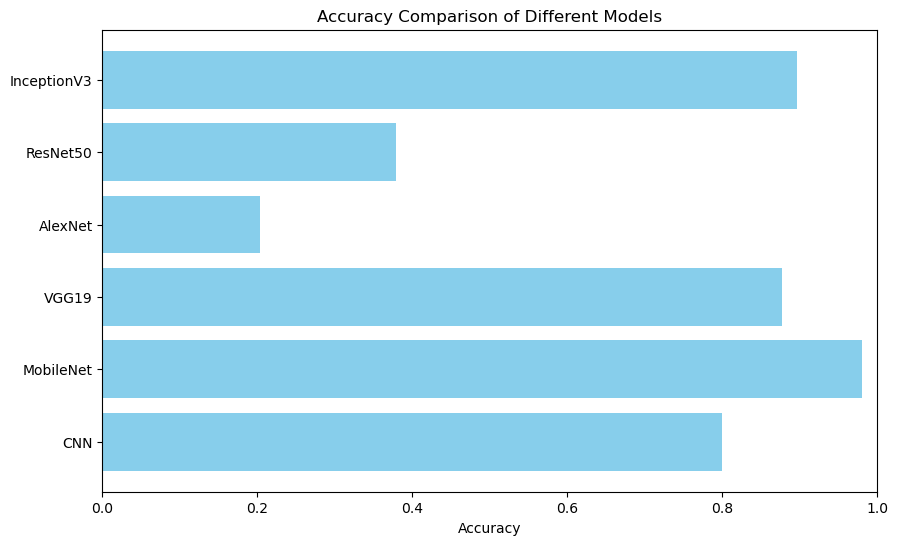

In [17]:
# Model names
models = ['CNN', 'MobileNet', 'VGG19', 'AlexNet', 'ResNet50', 'InceptionV3']
# Accuracies
accuracies = [cnn_accuracy, mobilenet_accuracy, vgg19_accuracy, alexnet_accuracy, resnet50_accuracy, inceptionv3_accuracy]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.xlim(0, 1)
plt.show()


# Training and Validation Accuracy and Loss Curves

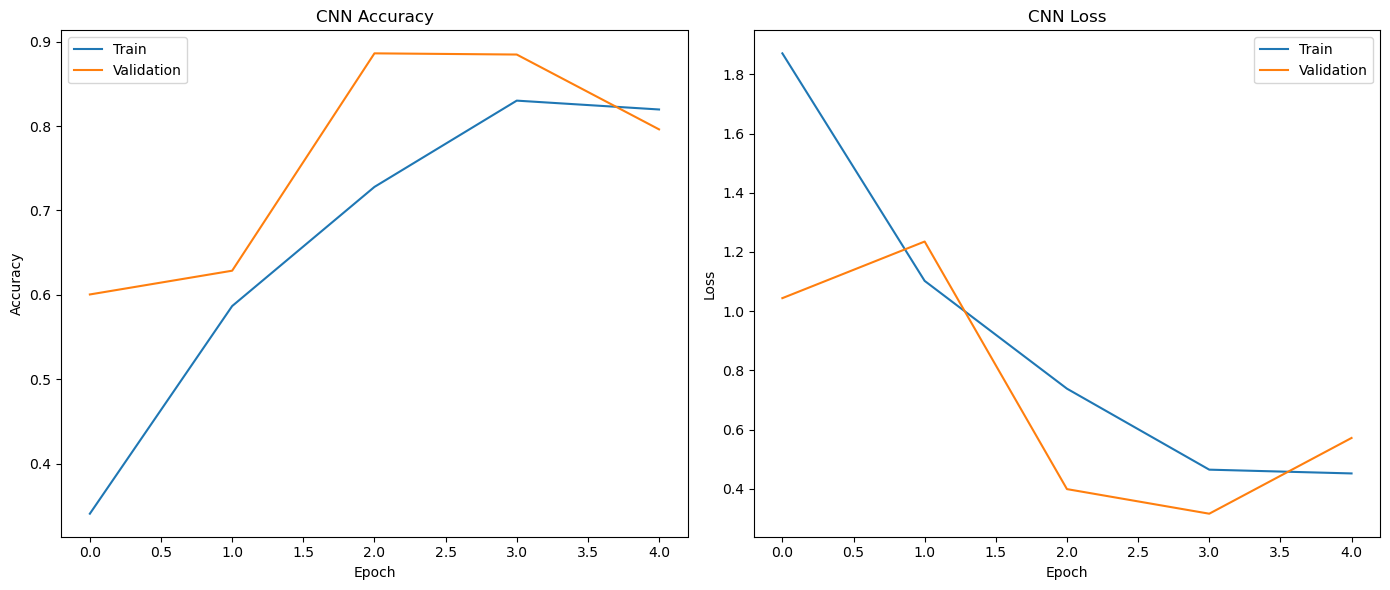

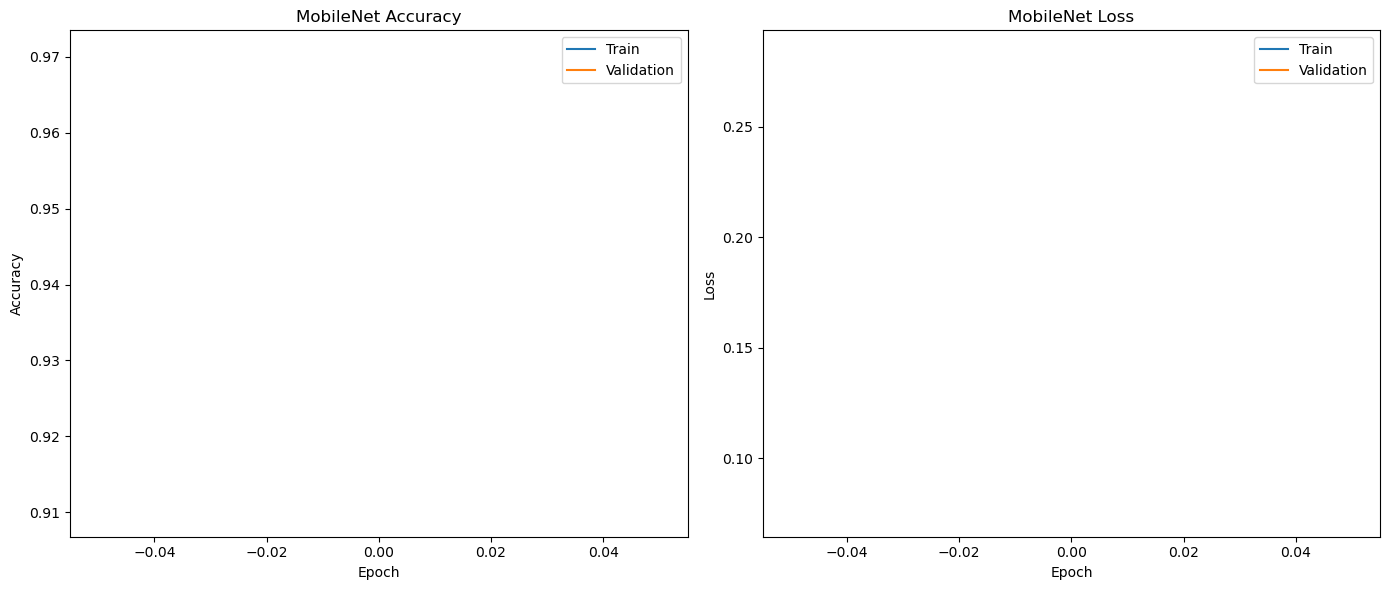

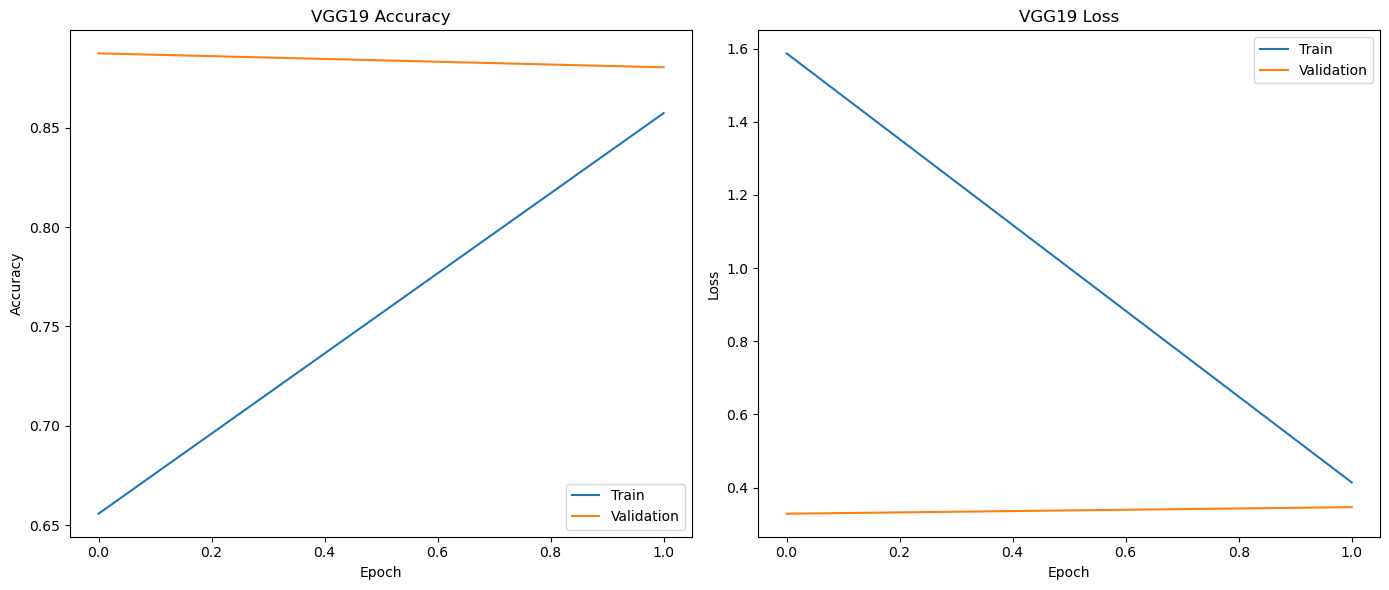

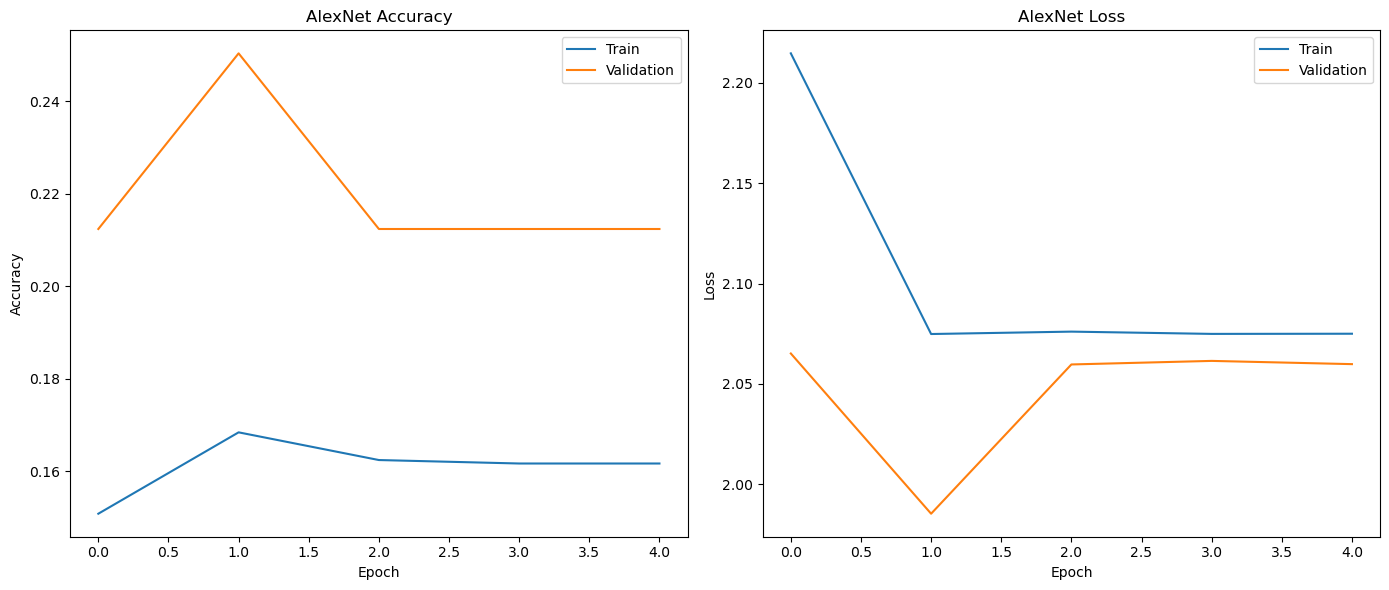

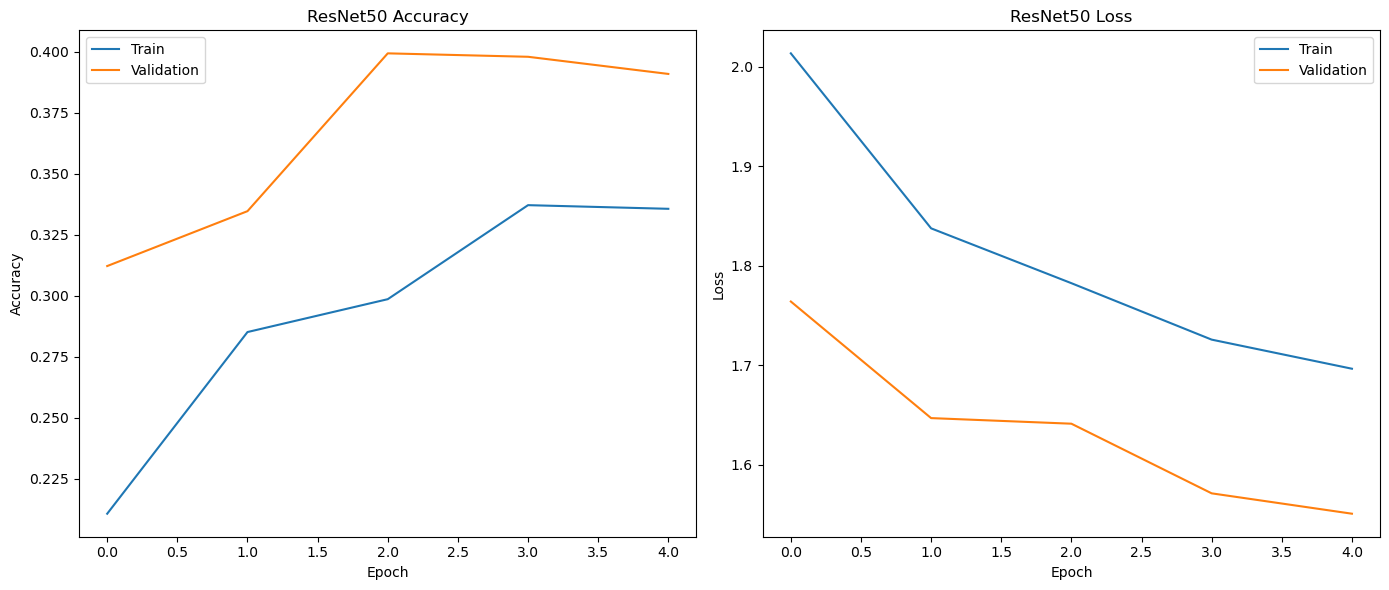

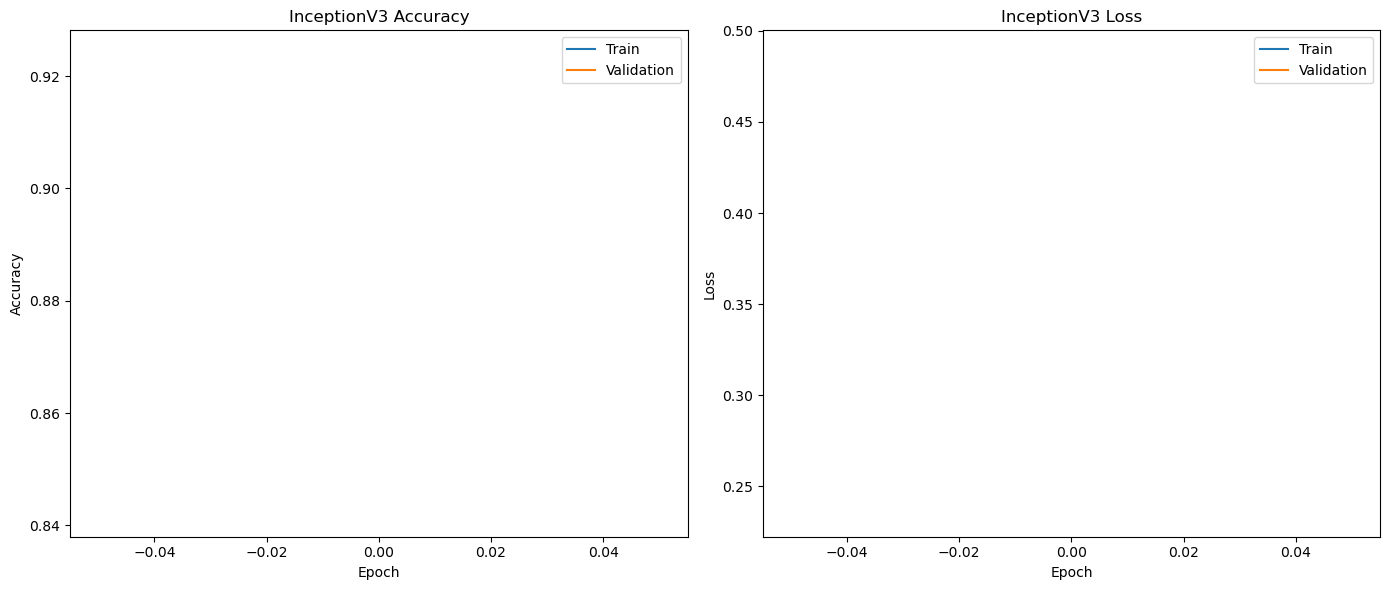

In [18]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

# Plot for each model
plot_training_history(cnn_history, 'CNN')
plot_training_history(mobilenet_history, 'MobileNet')
plot_training_history(vgg19_history, 'VGG19')
plot_training_history(alexnet_history, 'AlexNet')
plot_training_history(resnet50_history, 'ResNet50')
plot_training_history(inceptionv3_history, 'InceptionV3')


In [19]:
# Check what keys are available in the history object
print(cnn_history.history.keys())
print(mobilenet_history.history.keys())
print(vgg19_history.history.keys())
print(alexnet_history.history.keys())
print(resnet50_history.history.keys())
print(inceptionv3_history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Confusion Matrix

28/28 [==============================] - 7s 238ms/step


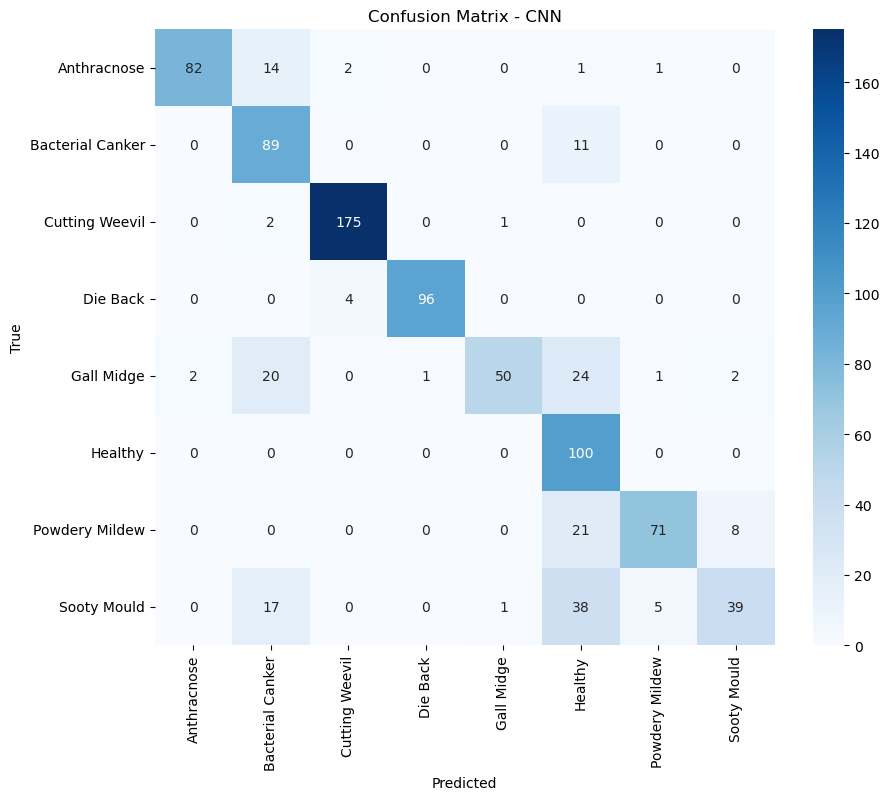

28/28 [==============================] - 11s 358ms/step


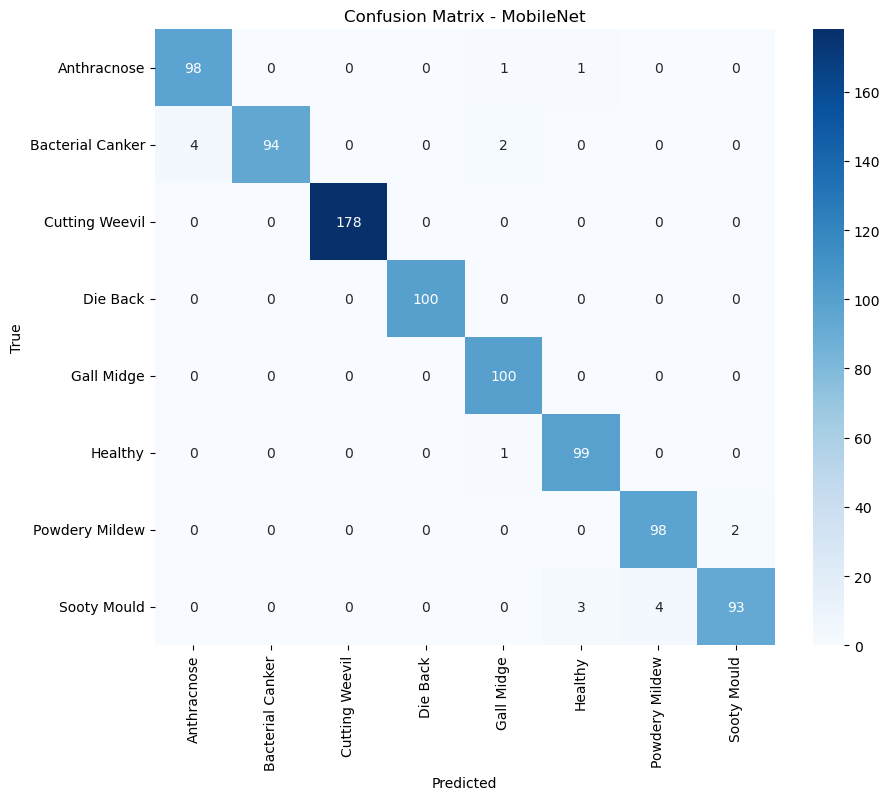

28/28 [==============================] - 186s 7s/step


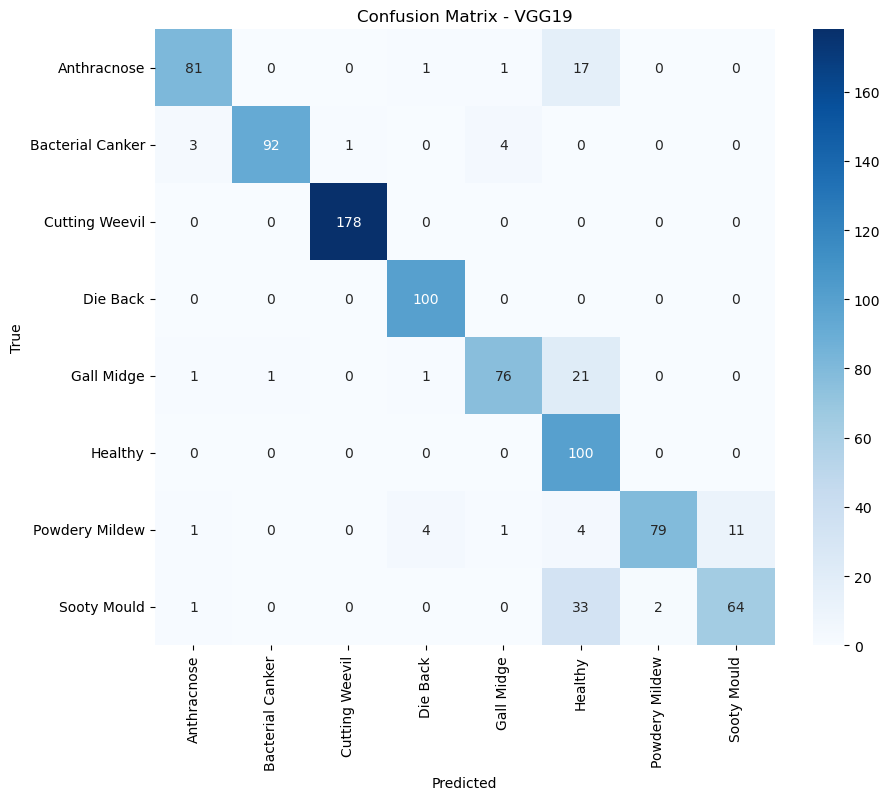

28/28 [==============================] - 9s 295ms/step


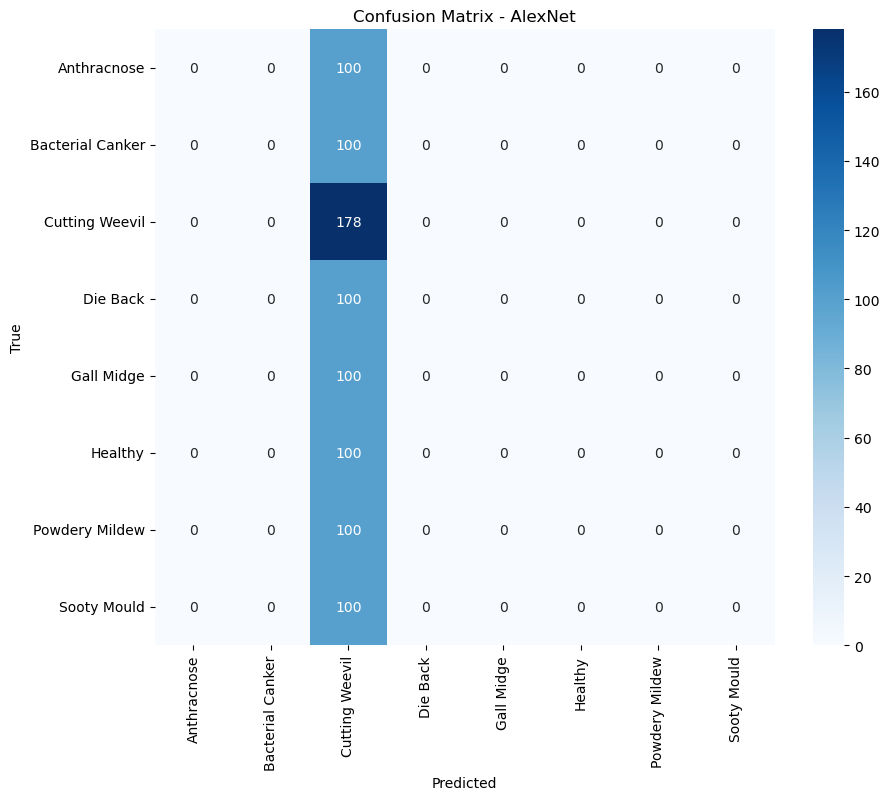

28/28 [==============================] - 54s 2s/step


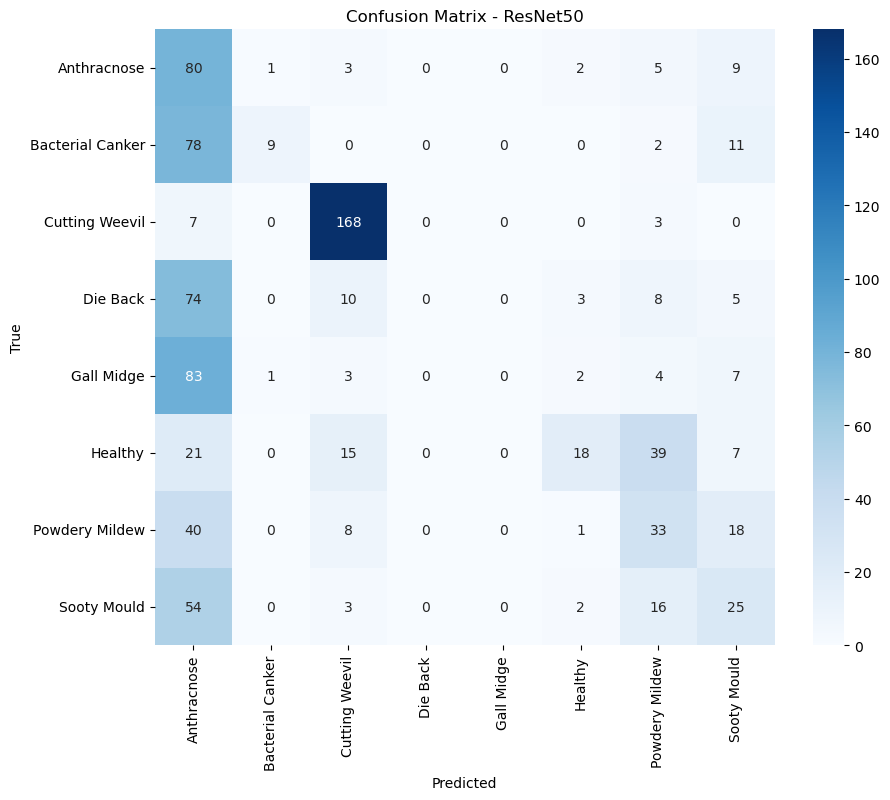

28/28 [==============================] - 34s 1s/step


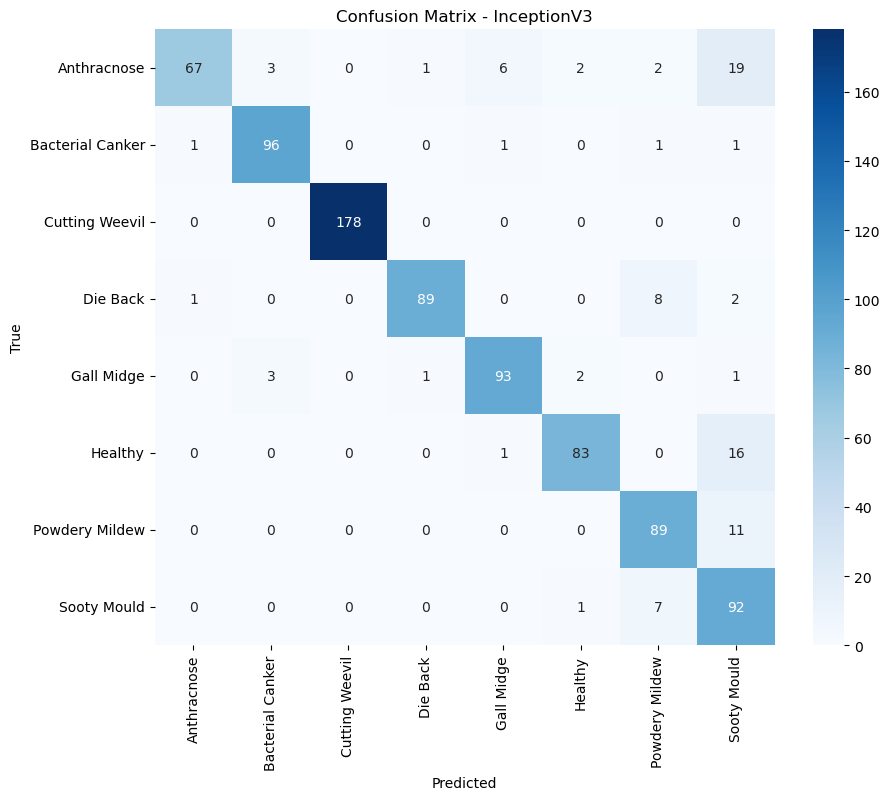

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_generator, class_labels, model_name):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot for each model
class_labels = list(test_generator.class_indices.keys())
plot_confusion_matrix(cnn_model, test_generator, class_labels, 'CNN')
plot_confusion_matrix(mobilenet_model, test_generator, class_labels, 'MobileNet')
plot_confusion_matrix(vgg19_model, test_generator, class_labels, 'VGG19')
plot_confusion_matrix(alexnet_model, test_generator, class_labels, 'AlexNet')
plot_confusion_matrix(resnet50_model, test_generator, class_labels, 'ResNet50')
plot_confusion_matrix(inceptionv3_model, test_generator, class_labels, 'InceptionV3')


# Classification Report

In [21]:
from sklearn.metrics import classification_report

def print_classification_report(model, test_generator, class_labels, model_name):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    report = classification_report(y_true, y_pred_classes, target_names=class_labels)
    print(f'Classification Report - {model_name}')
    print(report)

# Print report for each model
print_classification_report(cnn_model, test_generator, class_labels, 'CNN')
print_classification_report(mobilenet_model, test_generator, class_labels, 'MobileNet')
print_classification_report(vgg19_model, test_generator, class_labels, 'VGG19')
print_classification_report(alexnet_model, test_generator, class_labels, 'AlexNet')
print_classification_report(resnet50_model, test_generator, class_labels, 'ResNet50')
print_classification_report(inceptionv3_model, test_generator, class_labels, 'InceptionV3')


28/28 [==============================] - 7s 231ms/step
Classification Report - CNN
                  precision    recall  f1-score   support

     Anthracnose       0.98      0.82      0.89       100
Bacterial Canker       0.63      0.89      0.74       100
  Cutting Weevil       0.97      0.98      0.97       178
        Die Back       0.99      0.96      0.97       100
      Gall Midge       0.96      0.50      0.66       100
         Healthy       0.51      1.00      0.68       100
  Powdery Mildew       0.91      0.71      0.80       100
     Sooty Mould       0.80      0.39      0.52       100

        accuracy                           0.80       878
       macro avg       0.84      0.78      0.78       878
    weighted avg       0.85      0.80      0.80       878

28/28 [==============================] - 9s 332ms/step
Classification Report - MobileNet
                  precision    recall  f1-score   support

     Anthracnose       0.96      0.98      0.97       100
Bacterial Ca

C:\Users\BHARGAV\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARGAV\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARGAV\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 46s 2s/step
Classification Report - ResNet50
                  precision    recall  f1-score   support

     Anthracnose       0.18      0.80      0.30       100
Bacterial Canker       0.82      0.09      0.16       100
  Cutting Weevil       0.80      0.94      0.87       178
        Die Back       0.00      0.00      0.00       100
      Gall Midge       0.00      0.00      0.00       100
         Healthy       0.64      0.18      0.28       100
  Powdery Mildew       0.30      0.33      0.31       100
     Sooty Mould       0.30      0.25      0.27       100

        accuracy                           0.38       878
       macro avg       0.38      0.32      0.27       878
    weighted avg       0.42      0.38      0.33       878



C:\Users\BHARGAV\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARGAV\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARGAV\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 30s 1s/step
Classification Report - InceptionV3
                  precision    recall  f1-score   support

     Anthracnose       0.97      0.67      0.79       100
Bacterial Canker       0.94      0.96      0.95       100
  Cutting Weevil       1.00      1.00      1.00       178
        Die Back       0.98      0.89      0.93       100
      Gall Midge       0.92      0.93      0.93       100
         Healthy       0.94      0.83      0.88       100
  Powdery Mildew       0.83      0.89      0.86       100
     Sooty Mould       0.65      0.92      0.76       100

        accuracy                           0.90       878
       macro avg       0.90      0.89      0.89       878
    weighted avg       0.91      0.90      0.90       878



# Accuracy Comparison Bar Plot

28/28 [==============================] - 30s 1s/step - loss: 0.2683 - accuracy: 0.8964


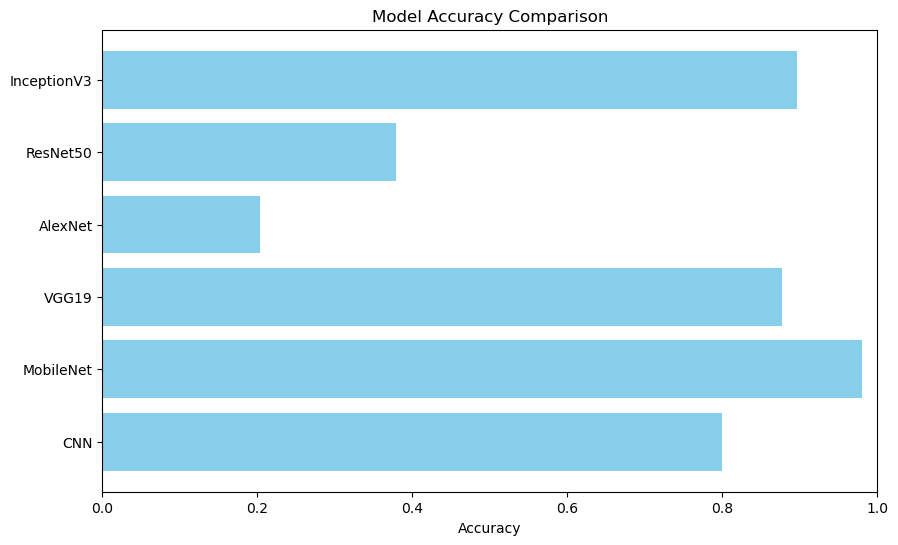

In [22]:
def plot_accuracy_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.barh(models, accuracies, color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlim(0, 1)
    plt.show()

# Prepare data
models = ['CNN', 'MobileNet', 'VGG19', 'AlexNet', 'ResNet50', 'InceptionV3']
accuracies = [
    cnn_model.evaluate(test_generator)[1],
    mobilenet_model.evaluate(test_generator)[1],
    vgg19_model.evaluate(test_generator)[1],
    alexnet_model.evaluate(test_generator)[1],
    resnet50_model.evaluate(test_generator)[1],
    inceptionv3_model.evaluate(test_generator)[1]
]

plot_accuracy_comparison(models, accuracies)


# Visualize Misclassified Images

28/28 [==============================] - 7s 231ms/step


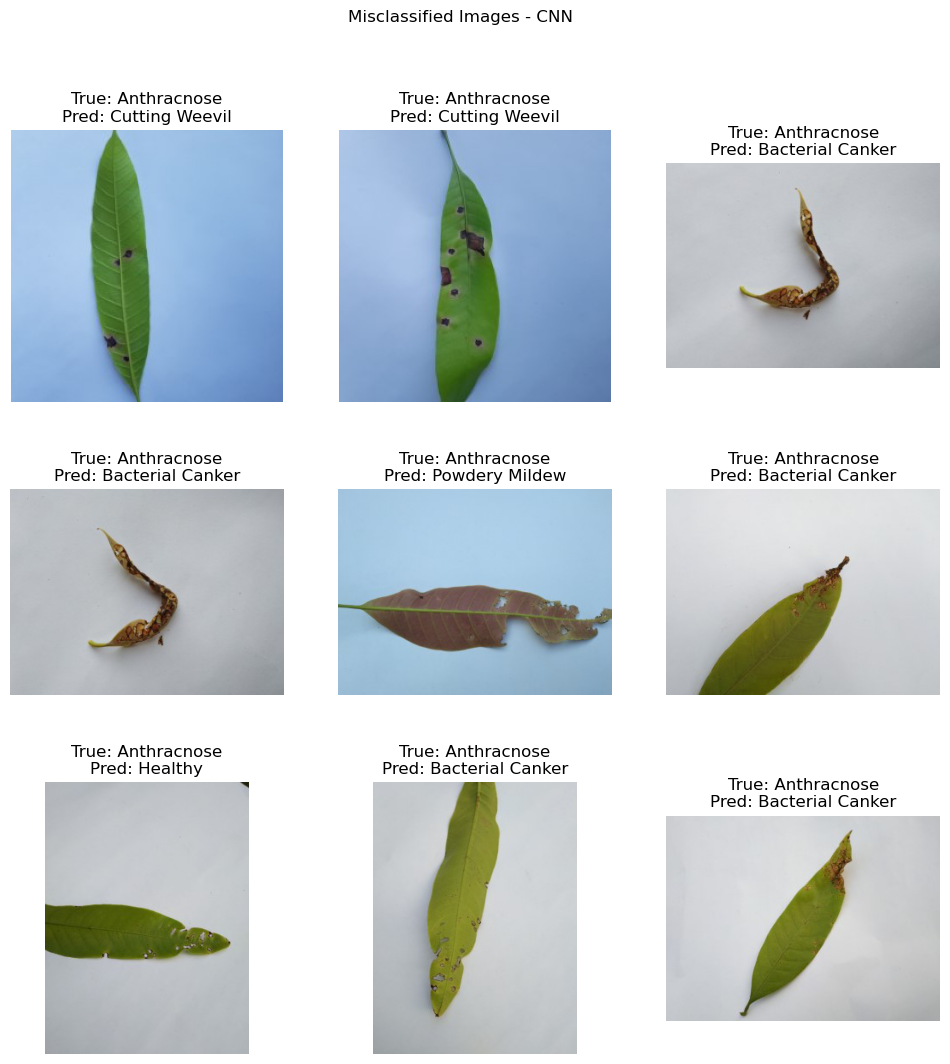

28/28 [==============================] - 10s 337ms/step


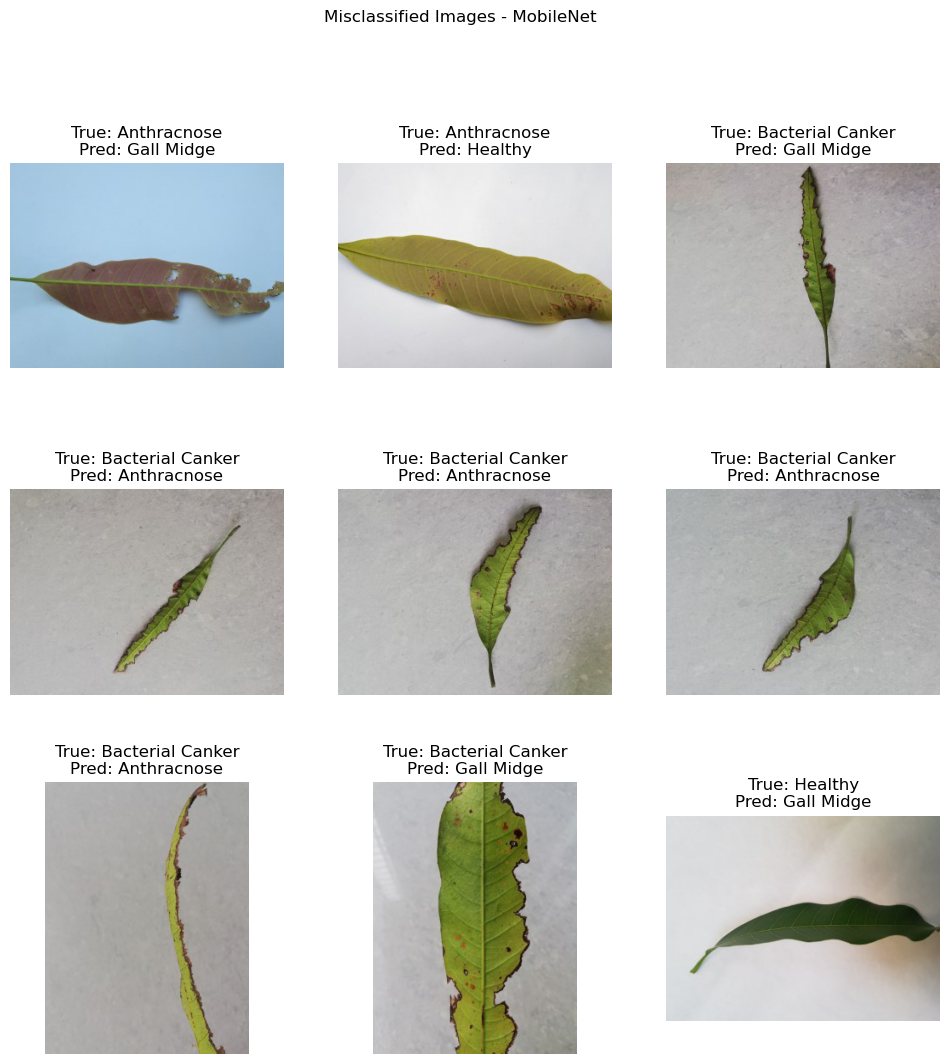

28/28 [==============================] - 186s 7s/step


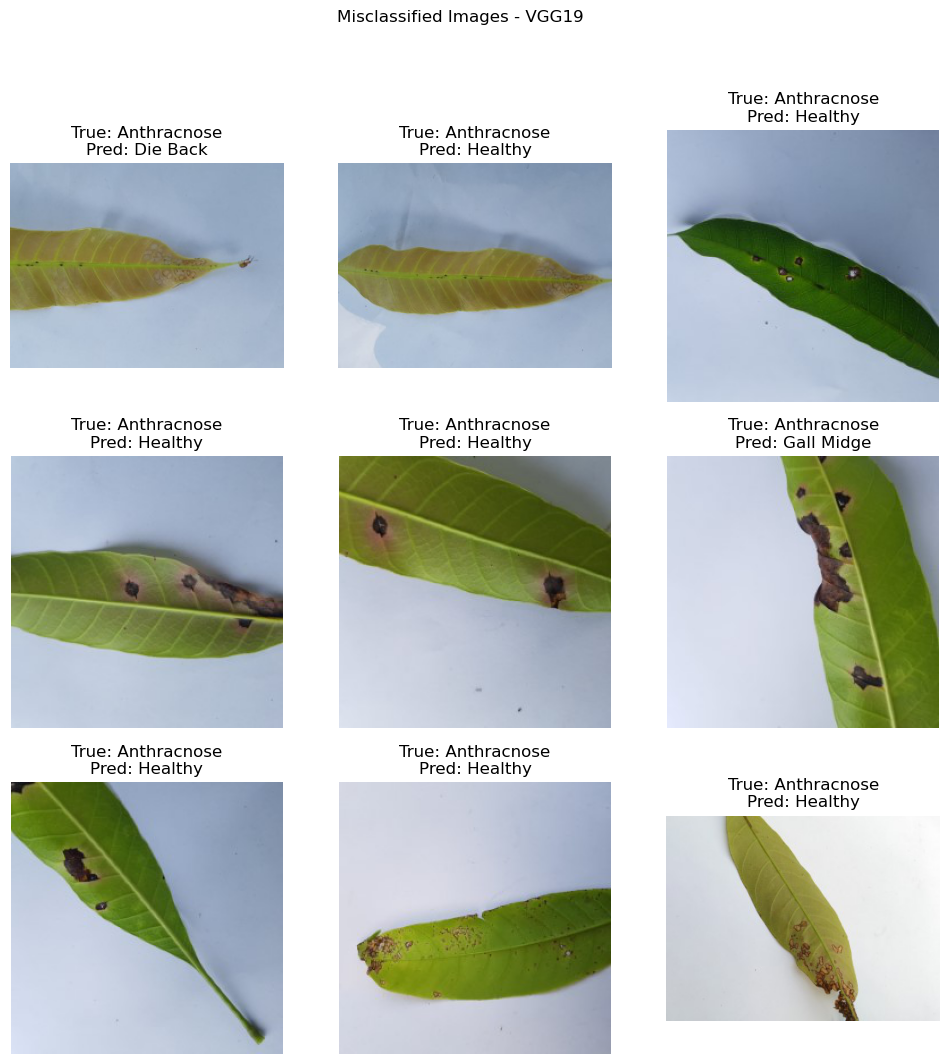

28/28 [==============================] - 8s 283ms/step


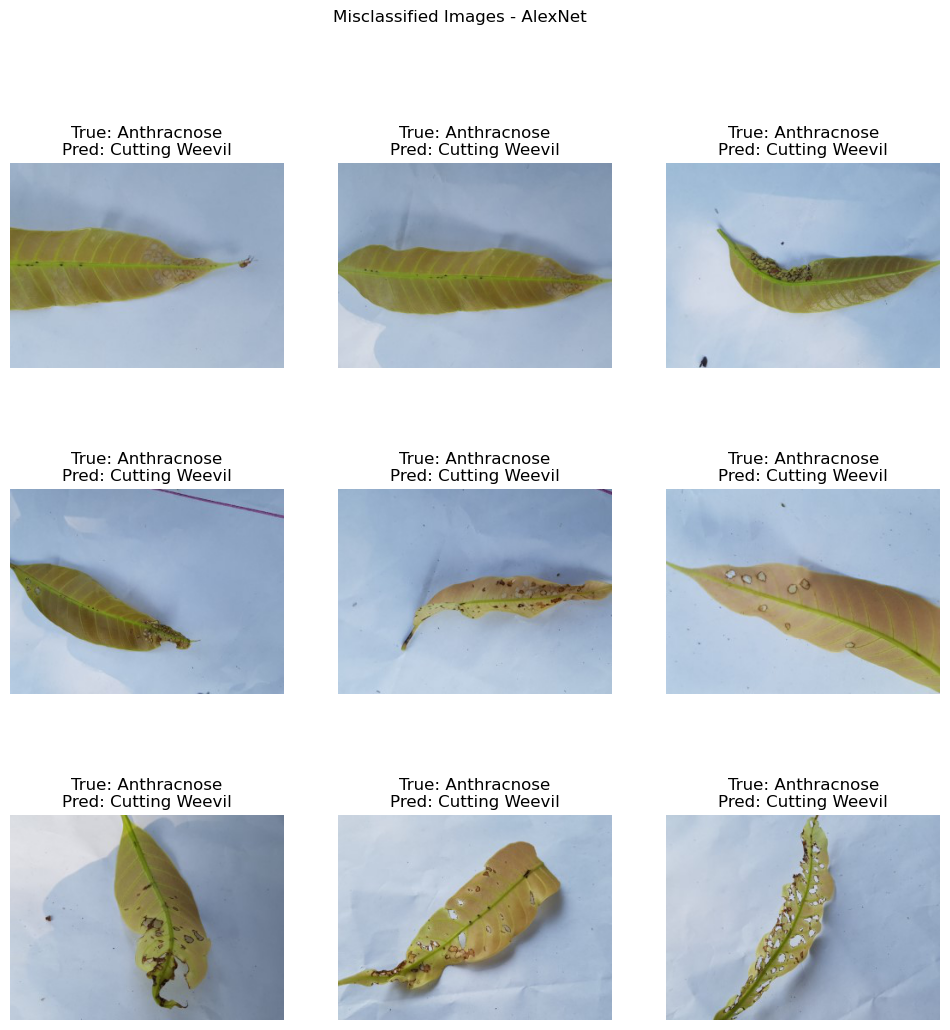

28/28 [==============================] - 46s 2s/step


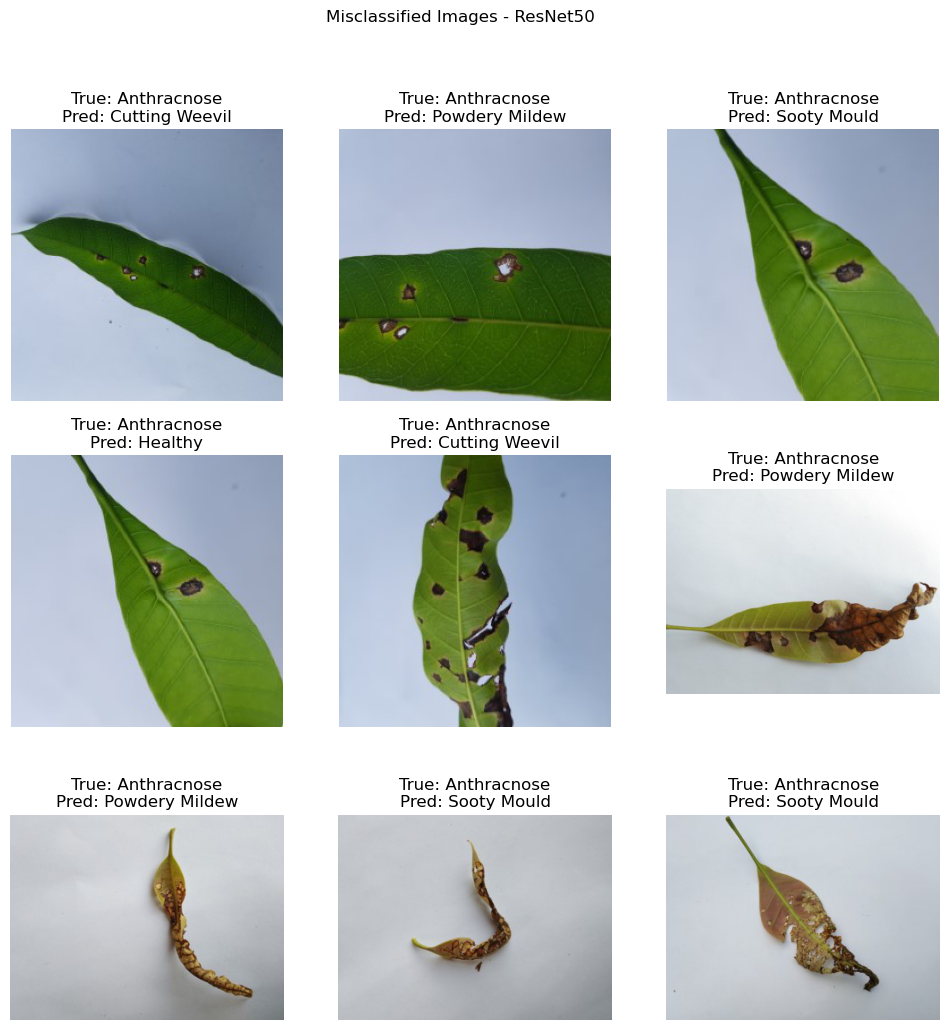

28/28 [==============================] - 30s 1s/step


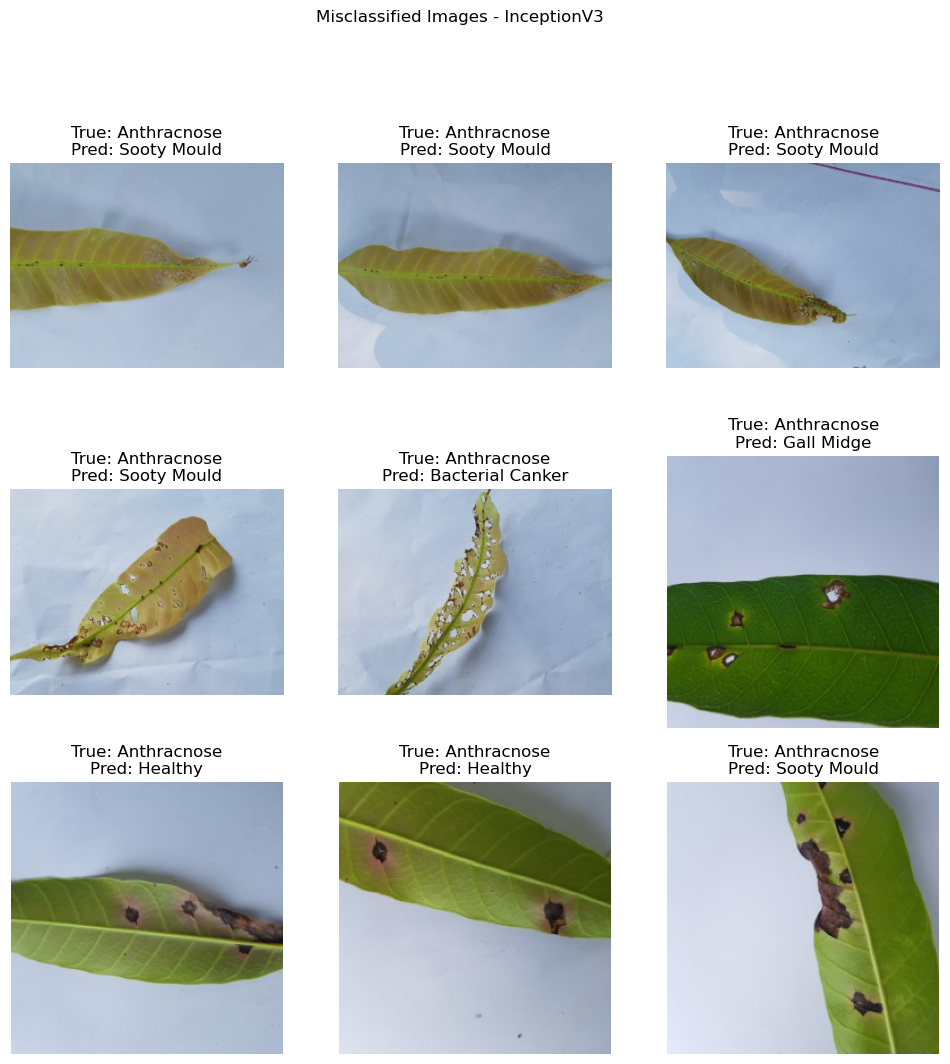

In [23]:
def plot_misclassified_images(model, test_generator, class_labels, model_name):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    misclassified_indices = np.where(y_true != y_pred_classes)[0]
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(misclassified_indices[:9]):
        plt.subplot(3, 3, i+1)
        img = test_generator.filepaths[idx]
        img = plt.imread(img)
        plt.imshow(img)
        plt.title(f'True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred_classes[idx]]}')
        plt.axis('off')
    
    plt.suptitle(f'Misclassified Images - {model_name}')
    plt.show()

# Plot for each model
plot_misclassified_images(cnn_model, test_generator, class_labels, 'CNN')
plot_misclassified_images(mobilenet_model, test_generator, class_labels, 'MobileNet')
plot_misclassified_images(vgg19_model, test_generator, class_labels, 'VGG19')
plot_misclassified_images(alexnet_model, test_generator, class_labels, 'AlexNet')
plot_misclassified_images(resnet50_model, test_generator, class_labels, 'ResNet50')
plot_misclassified_images(inceptionv3_model, test_generator, class_labels, 'InceptionV3')


# Testing

In [24]:
# Assuming 'model' is your trained model (CNN, MobileNet, etc.)
model.save('mango_leaf_disease_model.h5')

C:\Users\BHARGAV\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 797ms/step


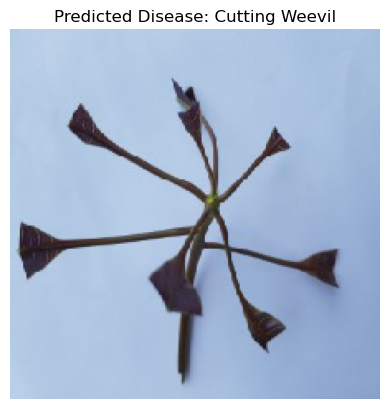

The predicted disease is: Cutting Weevil


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('mango_leaf_disease_model.h5')

# Dictionary to map class indices to disease names
disease_dict = {
    0: 'Anthracnose',
    1: 'Bacterial Canker',
    2: 'Cutting Weevil',
    3: 'Die Back',
    4: 'Gall Midge',
    5: 'Healthy',
    6: 'Powedery Mildew',
    7: 'Sooty Mould'
}

# Function to predict disease
def predict_disease(image_path):
    # Load the image
    img = load_img(image_path, target_size=(224, 224))  # Resize to the input size required by the model
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest prediction score
    
    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Disease: {disease_dict[predicted_class]}")
    plt.axis('off')
    plt.show()
    
    return disease_dict[predicted_class]

# Provide the path to the image you want to predict
image_path = r'C:\Users\BHARGAV\OneDrive\Desktop\Final Project\archive\Cutting Weevil\pic1.jpg'
predicted_disease = predict_disease(image_path)
print(f'The predicted disease is: {predicted_disease}')
